<h1 align="center"> Image Captioning (10 баллов) </h1>

В этом ноутбуке вы обучите сеть составлять подписи к изображениям.
![img](https://i.imgur.com/obITaMl.png)


#### План работы:

1. Использовать предобученную модель Inception v3 для преобразования изображений в векторы.

2. Добавить поверх неё LSTM.

3. Обучить модель на датасете [MSCOCO](http://cocodataset.org/#download).

### 1. Данные (0.5 балла)

In [ ]:
# Скачайте датасет по ссылке https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
BASE_PATH = '/content/drive/MyDrive/dataset/data'

In [3]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load(f"{BASE_PATH}/image_codes.npy")
with open(f'{BASE_PATH}/captions_tokenized.json', 'r') as f:
    captions = json.load(f)

CPU times: user 57.1 ms, sys: 701 ms, total: 758 ms
Wall time: 27.5 s



Чтобы сэкономить ваше время, мы уже преобразовали все изображения из MSCOCO17 в векторы с помощью предобученной сети Inception_v3 из библиотеки [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

Весь процесс занимает от одного дня на CPU до примерно 10 минут на трёх GPU Tesla M40. [Если хотите попробовать сделать это самостоятельно — пожалуйста.](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).


In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Как видно, все подписи уже токенизированы и приведены к нижнему регистру. Теперь нам нужно разделить их и добавить специальные токены, обозначающие начало и конец подписи.

In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


Мы не хотим, чтобы сеть на каждом шаге предсказывала вероятности для миллиона слов, поэтому нужно немного сократить словарь.

Для этого посчитайте, **сколько раз встречается каждое слово** — так мы сможем решить, какие слова оставить в словаре.

In [6]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions
for img_captions in captions:
    for caption in img_captions:
        for word in caption:
            word_counts[word] += 1

In [7]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [8]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [9]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### 2. Построение нейронной сети (1.5 балла)

Как уже упоминалось, мы создадим RNN-модель для генерации текста, которая будет зависеть от векторов, полученных из CNN-части сети.

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)

Во время обучения мы будем использовать уже готовые вектора-признаков, а сеть Inception добавим на этапе инференса.


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [11]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [12]:
network = CaptionNet(n_tokens)

In [13]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [16]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """

    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)


    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.

    loss = F.cross_entropy(
        logits_for_next.view(-1, logits_for_next.shape[-1]),
        captions_ix_next.view(-1),
        ignore_index=pad_ix
    )
    if loss.dim() == 0:
        loss = loss.unsqueeze(0)

    return loss

In [17]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'


Добавьте ~~adam~~ ваш любимы оптимизатор для обучения.

In [18]:
optimizer = torch.optim.SGD(network.parameters(), lr=1e-2, momentum=0.9)

### 3. Обучение (5 баллов)

* Сначала реализуйте генератор батчей.
* Затем обучите сеть как обычно.

In [24]:
from sklearn.model_selection import train_test_split
captions = np.array(captions, dtype=object)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)
print(f"Train images: {len(train_img_codes)}")
print(f"Val images: {len(val_img_codes)}")
print(f"Train captions: {len(train_captions)}")
print(f"Val captions: {len(val_captions)}")

Train images: 106458
Val images: 11829
Train captions: 106458
Val captions: 11829


In [25]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)


In [26]:
generate_batch(img_codes,captions,3)

(tensor([[0.5288, 0.0449, 0.4187,  ..., 0.1569, 0.5024, 0.1039],
         [0.1024, 0.3105, 0.6716,  ..., 0.1704, 0.4062, 0.0971],
         [0.4272, 0.4201, 0.6040,  ..., 0.0769, 0.9453, 0.0330]]),
 tensor([[   1,   24,  373,  357,  136,   24,   46,  350,  889,   35,  156,   50,
           351,  413,   12,    2],
         [   1,   24, 7624,  447,   18,   24,  290, 2611,  964,   24, 1822,   12,
             2,    3,    3,    3],
         [   1,   45,  278,  693,   99,   35,   77,   14,   45, 1287,   35,   45,
          1844,   12,    2,    3]]))

Обучайте модель на мини-батчах, как обычно. Периодически проверяйте качество на валидационном наборе.

#### **Советы**

* Если тренировочный лосс почти равен нулю или модель генерирует бессмысленный текст — проверьте, что вы предсказываете следующее слово, а не текущее или слово через два шага.

* Если модель создаёт плавные, но нерелевантные описания:

  * возможно, рекуррентная сеть не получает векторы изображения;

  * также это может быть следствием взрыва градиентов — попробуйте клиппинг или перезапуск обучения;

  * наконец, возможно, модель просто нужно обучить дольше.

* Кросс-энтропия — слабый показатель переобучения:

  * модель может переобучиться по валидационной кросс-энтропии, но при этом продолжать улучшать качество генерации;

  * используйте ручную оценку или автоматические метрики, такие как CIDEr или BLEU.

* Рекомендуется периодически проверять сеть с помощью блока “apply trained model” — можно остановить обучение, протестировать несколько примеров и продолжить.

* Типичные значения функции потерь: около 3–5, если усреднять по времени,
или масштабировать по длине при суммировании. Разумные подписи начинают появляться при лоссе 2.8–3.0.

In [27]:
batch_size = 50  # adjust me
n_epochs = 50  # adjust me 100
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [28]:
from tqdm import tqdm

for epoch in range(n_epochs):

    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):

        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))


        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()

        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:21<00:00,  2.30it/s]



Epoch: 0, train loss: 9.06583547592163, val loss: 8.733297538757324


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]



Epoch: 1, train loss: 8.231808052062988, val loss: 7.7160964012146


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]



Epoch: 2, train loss: 6.985204133987427, val loss: 6.343092346191407


100%|██████████| 50/50 [00:20<00:00,  2.40it/s]



Epoch: 3, train loss: 6.077333116531372, val loss: 5.999033451080322


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]



Epoch: 4, train loss: 5.7642027854919435, val loss: 5.638481998443604


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]



Epoch: 5, train loss: 5.491147012710571, val loss: 5.399560737609863


100%|██████████| 50/50 [00:22<00:00,  2.25it/s]



Epoch: 6, train loss: 5.2926694107055665, val loss: 5.190338230133056


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]



Epoch: 7, train loss: 5.211685295104981, val loss: 5.193160057067871


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]



Epoch: 8, train loss: 5.098299407958985, val loss: 4.9701769828796385


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]



Epoch: 9, train loss: 4.983533592224121, val loss: 4.997088050842285


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]



Epoch: 10, train loss: 4.91199031829834, val loss: 4.872847080230713


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]



Epoch: 11, train loss: 4.879786434173584, val loss: 4.879188919067383


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]



Epoch: 12, train loss: 4.809407291412353, val loss: 4.776391506195068


100%|██████████| 50/50 [00:24<00:00,  2.01it/s]



Epoch: 13, train loss: 4.779938068389892, val loss: 4.740921115875244


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]



Epoch: 14, train loss: 4.697060060501099, val loss: 4.728989505767823


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]



Epoch: 15, train loss: 4.68943377494812, val loss: 4.7404779434204105


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]



Epoch: 16, train loss: 4.62772008895874, val loss: 4.631374931335449


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]



Epoch: 17, train loss: 4.598723192214965, val loss: 4.680633926391602


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]



Epoch: 18, train loss: 4.5949545574188235, val loss: 4.506342601776123


100%|██████████| 50/50 [00:24<00:00,  2.00it/s]



Epoch: 19, train loss: 4.583778247833252, val loss: 4.560283470153808


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]



Epoch: 20, train loss: 4.515933208465576, val loss: 4.537413787841797


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]



Epoch: 21, train loss: 4.5280021381378175, val loss: 4.476198768615722


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]



Epoch: 22, train loss: 4.474941673278809, val loss: 4.428139019012451


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]



Epoch: 23, train loss: 4.461247215270996, val loss: 4.478244018554688


100%|██████████| 50/50 [00:23<00:00,  2.08it/s]



Epoch: 24, train loss: 4.448325605392456, val loss: 4.509730434417724


100%|██████████| 50/50 [00:23<00:00,  2.12it/s]



Epoch: 25, train loss: 4.453433656692505, val loss: 4.476879596710205


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]



Epoch: 26, train loss: 4.448437194824219, val loss: 4.561016178131103


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]



Epoch: 27, train loss: 4.370636329650879, val loss: 4.416446304321289


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]



Epoch: 28, train loss: 4.365666427612305, val loss: 4.399157905578614


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]



Epoch: 29, train loss: 4.37041485786438, val loss: 4.370830535888672


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]



Epoch: 30, train loss: 4.343433990478515, val loss: 4.360263442993164


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]



Epoch: 31, train loss: 4.369742012023925, val loss: 4.28174934387207


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]



Epoch: 32, train loss: 4.334554052352905, val loss: 4.286331272125244


100%|██████████| 50/50 [00:24<00:00,  2.08it/s]



Epoch: 33, train loss: 4.29314001083374, val loss: 4.363003492355347


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]



Epoch: 34, train loss: 4.309799795150757, val loss: 4.277675151824951


100%|██████████| 50/50 [00:25<00:00,  1.93it/s]



Epoch: 35, train loss: 4.284803400039673, val loss: 4.301234245300293


100%|██████████| 50/50 [00:23<00:00,  2.11it/s]



Epoch: 36, train loss: 4.290510950088501, val loss: 4.307779312133789


100%|██████████| 50/50 [00:22<00:00,  2.19it/s]



Epoch: 37, train loss: 4.236800756454468, val loss: 4.270155143737793


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]



Epoch: 38, train loss: 4.2155837392807, val loss: 4.267977046966553


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]



Epoch: 39, train loss: 4.258129940032959, val loss: 4.198534631729126


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]



Epoch: 40, train loss: 4.246574783325196, val loss: 4.14488468170166


100%|██████████| 50/50 [00:23<00:00,  2.09it/s]



Epoch: 41, train loss: 4.201728949546814, val loss: 4.148517370223999


100%|██████████| 50/50 [00:24<00:00,  2.05it/s]



Epoch: 42, train loss: 4.175585680007934, val loss: 4.140825939178467


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]



Epoch: 43, train loss: 4.202640585899353, val loss: 4.120178508758545


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]



Epoch: 44, train loss: 4.164635667800903, val loss: 4.150337600708008


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]



Epoch: 45, train loss: 4.123608827590942, val loss: 4.2508848190307615


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]



Epoch: 46, train loss: 4.1754041242599484, val loss: 4.263507080078125


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]



Epoch: 47, train loss: 4.170689430236816, val loss: 4.101232051849365


100%|██████████| 50/50 [00:23<00:00,  2.14it/s]



Epoch: 48, train loss: 4.1487200784683225, val loss: 4.244308948516846


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]



Epoch: 49, train loss: 4.132232236862182, val loss: 4.059309816360473
Finished!


### 4. Применяем обученную модель (0.5 балла)

Теперь загрузим предобученнную Inceprion модель и посмотрим, на что способна наша модель.


In [30]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


100%|██████████| 104M/104M [00:00<00:00, 211MB/s] 


#### **Генерируем подписи**

Функция ниже генерирует подписи, выбирая слова на основе вероятностей, предсказанных моделью.

Реализация здесь простая, но неэффективная (её сложность квадратична по числу шагов LSTM).

In [31]:
def generate_caption(image, caption_prefix=("#START#",),
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3

    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break

    return caption_prefix

In [36]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os

# Создаем папку data если ее нет
os.makedirs('data', exist_ok=True)

# Скачиваем картинку
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg

# Загружаем картинку
img = Image.open('data/img.jpg')

# Меняем размер картинки
img = img.resize((299, 299))

# Преобразуем в numpy массив и нормализуем
img = np.array(img)
img = img.astype('float32') / 255.0

--2025-10-30 18:49:36--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-30 18:49:37--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K   263KB/s    in 0.2s    

2025-10-30 18:49:38 (263 KB/s) - ‘data/img.jpg’ saved [54731/5473

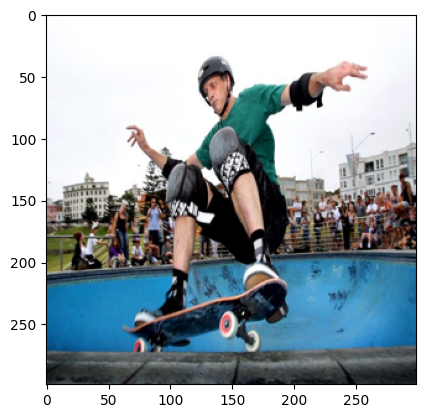

In [37]:
plt.imshow(img)

In [38]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man in a man in a field .
a man is a tennis on a field .
a man is a man in a field .
a man is a woman in a field .
a man is a man on a field .
a man in a field in a field .
a man is sitting on a table with a tennis .
a man is a tennis on a table .
a man is a tennis in a field .
a man is sitting on a field with a large .


--2025-10-30 18:53:19--  https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237844 (232K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 232.27K  --.-KB/s    in 0.007s  

2025-10-30 18:53:19 (30.6 MB/s) - ‘data/img.jpg’ saved [237844/237844]



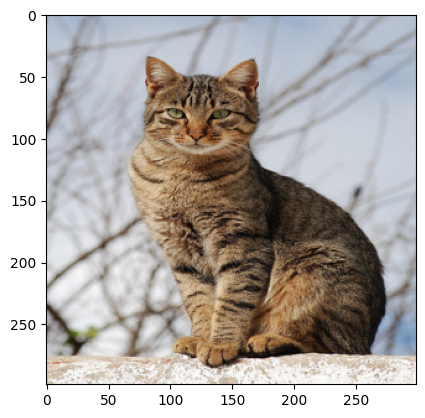

a man is a white holding a tennis .
a man is a white and a motorcycle .
a cat is a tennis in a street .
a person on a table with a skateboard .
a white and white sitting on a table .
a person in a street with a skateboard and a tennis .
a woman with a white and white and white and a white .
a person on a white plate with a large toilet .
a large white and white sitting on a skateboard .
a woman in a small and white dog in a field .


In [41]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/800px-Cat_November_2010-1a.jpg -O data/img.jpg

# Загружаем картинку
img = Image.open('data/img.jpg')

# Меняем размер картинки
img = img.resize((299, 299))

# Преобразуем в numpy массив и нормализуем
img = np.array(img)
img = img.astype('float32') / 255.0

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

### 5. Demo (2.5 балла)
##### **Найдите как минимум 10 изображений для теста.**

* Серьёзно, это часть задания — подготовьте хотя бы 10 картинок для генерации подписей.

* Сначала проверьте работу модели на простых изображениях, прежде чем переходить к более сложным.

* В вашем наборе должны быть примеры как удачных, так и неудачных подписей — проявите креативность :)

* Используйте фотографии, а не анимацию, 3D или рисунки — иначе придётся переобучать CNN на аниме.

* Обратите внимание на соотношение сторон изображений.

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
images_folder = BASE_PATH

import os
import glob

if os.path.exists(images_folder):
    files = os.listdir(images_folder)

image_paths = [os.path.join(images_folder, f) for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))]


print(f"\nНайдено изображений: {len(image_paths)}")



Найдено изображений: 13


In [55]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os
from IPython.display import display
%matplotlib inline

def load_image(path):
    """
    Загружает изображение и приводит его к размеру 299x299 для Inception v3
    """
    img = Image.open(path).convert('RGB')
    img = img.resize((299, 299), Image.LANCZOS)
    img_array = np.array(img).astype('float32') / 255.
    return img_array


def show_image_with_captions(image_path, num_captions=5, temperature=5.0, sample=True):
    """
    Показывает изображение и генерирует несколько подписей
    """
    img = load_image(image_path)

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {os.path.basename(image_path)}", fontsize=14)
    plt.show()

    print(f"\nGenerated captions (temperature={temperature}):")
    print("-" * 60)

    captions_list = []
    for i in range(num_captions):
        caption = ' '.join(generate_caption(img, t=temperature, sample=sample)[1:-1])
        captions_list.append(caption)
        print(f"{i+1}. {caption}")

    print("\n" + "="*80 + "\n")
    return captions_list


Image 1/13



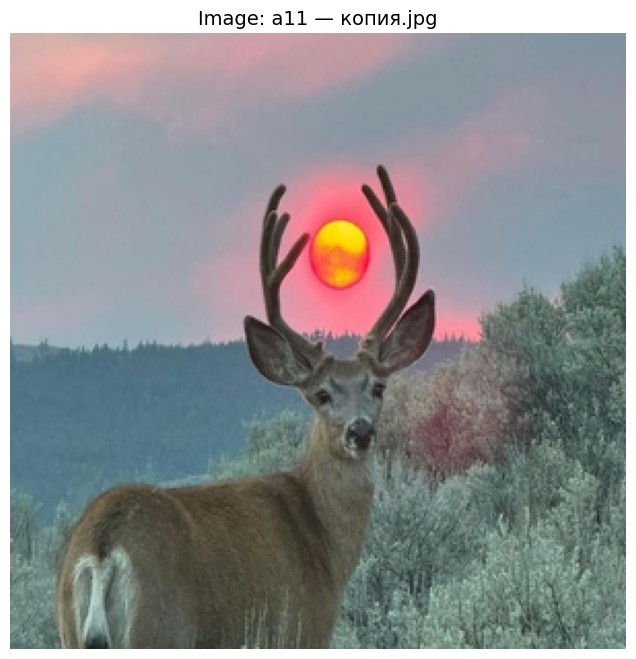


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a person is a white with a tennis
2. a person is a white in a field .
3. a group of people are in a field .
4. a large white and white sitting on a table .
5. a man in a street with a table .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a large white in a field .


Image 2/13



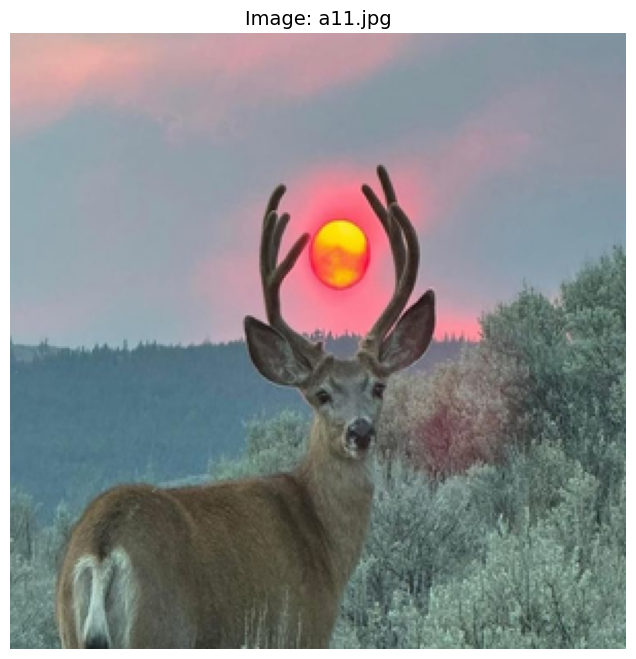


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a white in a field .
2. a man is a large white in a field .
3. a man in a large field with a street .
4. a large white dog is sitting on a field .
5. a man in a field with a man in a field .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a large white in a field .


Image 3/13



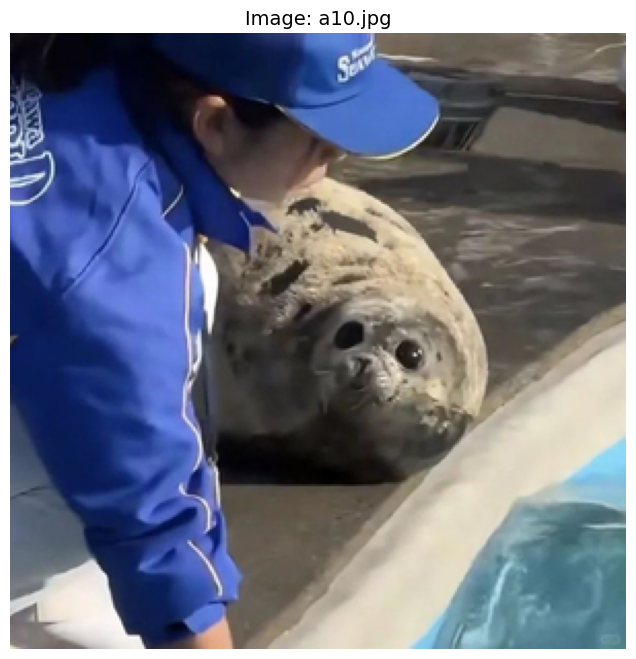


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man in a white holding a tennis
2. a man is a tennis in a field .
3. a man in a white sitting on a field .
4. a man in a black and a tennis field .
5. a person is a baseball on a street .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a tennis on a field .


Image 4/13



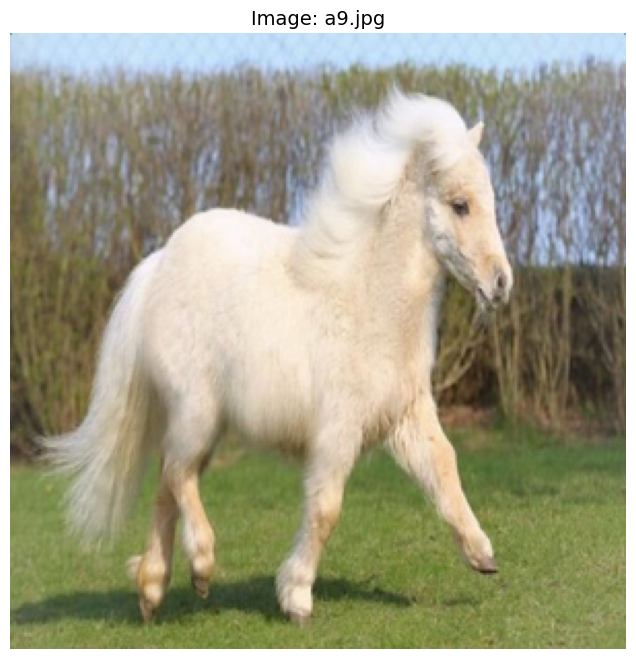


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a baseball in a table .
2. a man is a tennis in a field .
3. a man is a tennis on a table .
4. a man in a large white and a tennis .
5. a person with a man on a table .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a tennis on a field .


Image 5/13



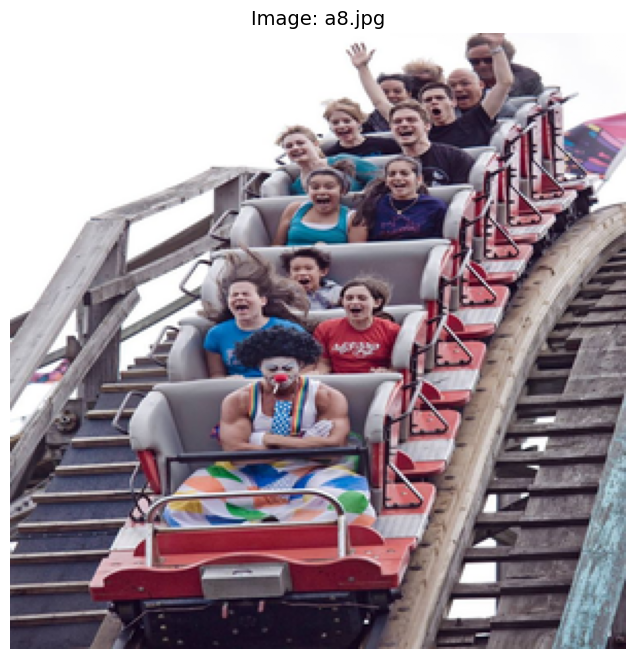


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a person with a blue and white and a table
2. a man with a large white and white and a dog .
3. a person on a street with a field .
4. a man is sitting on a field with a street .
5. a person with a large white and a street .


Most probable caption (greedy):
------------------------------------------------------------
→ a person with a white and white and a white .


Image 6/13



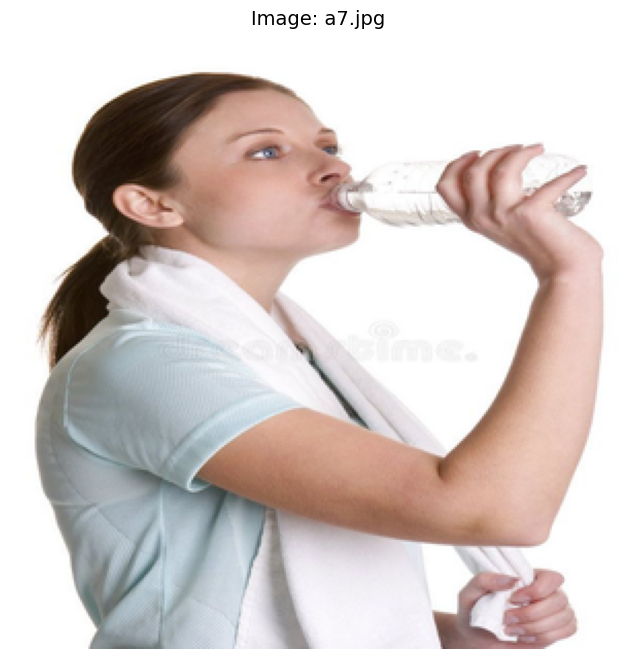


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a tennis in a field .
2. a man is a tennis on a street .
3. a man is a white and a tennis on a field .
4. a man is a skateboard with a large field .
5. a man on a small field with a table .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a tennis in a field .


Image 7/13



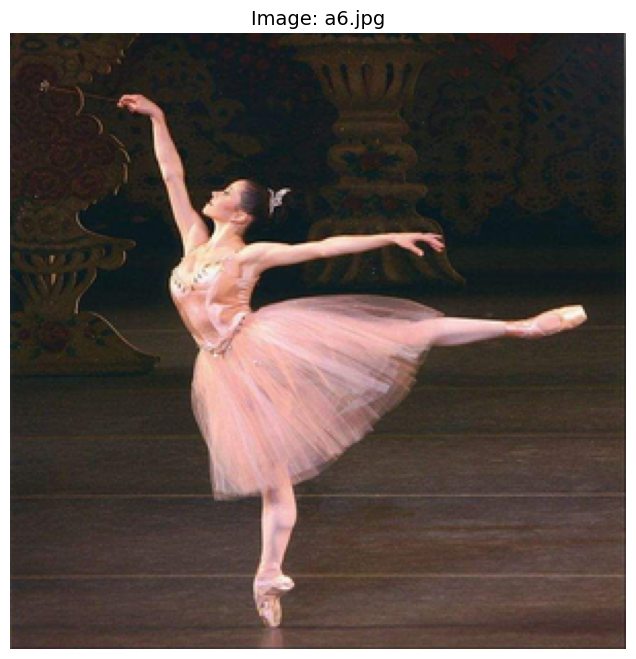


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man in a baseball field in a field .
2. a man is a tennis on a field .
3. a man is a man in a field .
4. a man in a black and a field holding a field .
5. a man riding a baseball on a field .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a tennis in a field .


Image 8/13



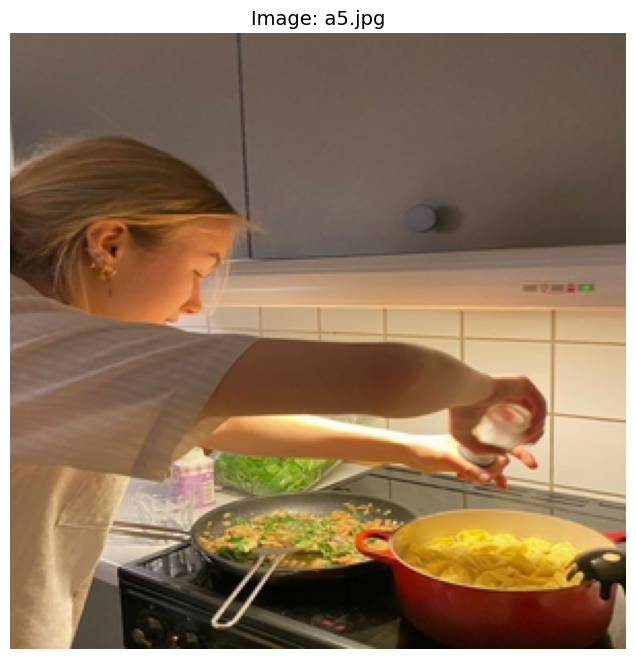


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a white sitting on a table .
2. a man in a white and a white dog in a field .
3. a man is a tennis on a field
4. a man is a baseball with a man in a field
5. a man is a man in a field


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a woman in a field .


Image 9/13



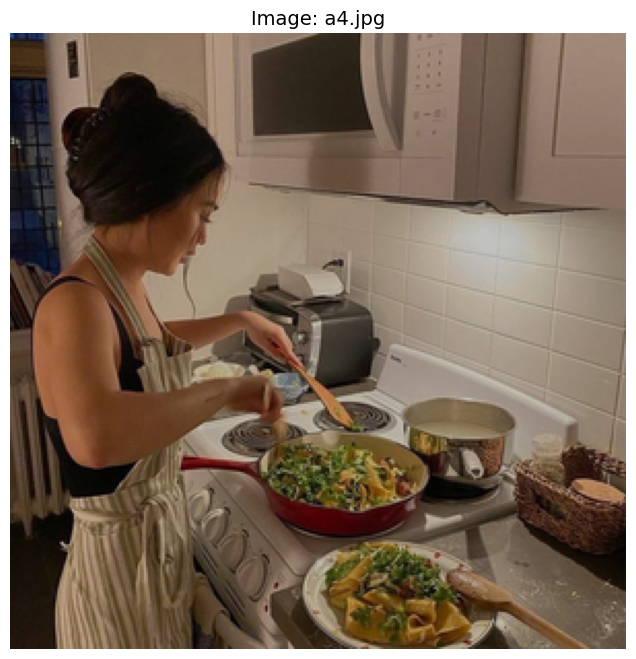


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a woman with a toilet and a white and white .
2. a man is sitting on a table with a table .
3. a man with a white and white and white and a white .
4. a man with a white and white and white and white .
5. a man with a white and white and white .


Most probable caption (greedy):
------------------------------------------------------------
→ a man with a white and white and white and a white .


Image 10/13



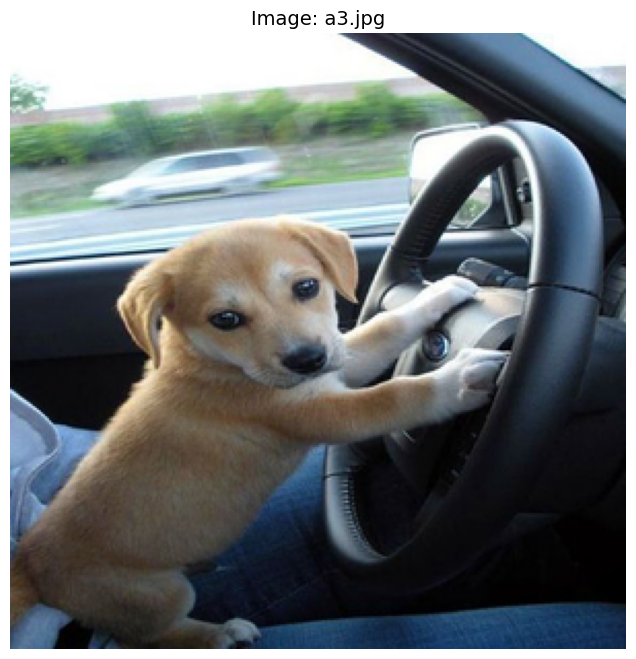


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a white in a field .
2. a man is a large white in a field .
3. a man sitting on a white field .
4. a man is a black and white in a field .
5. a man is a large white and a man on a field


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a white in a field .


Image 11/13



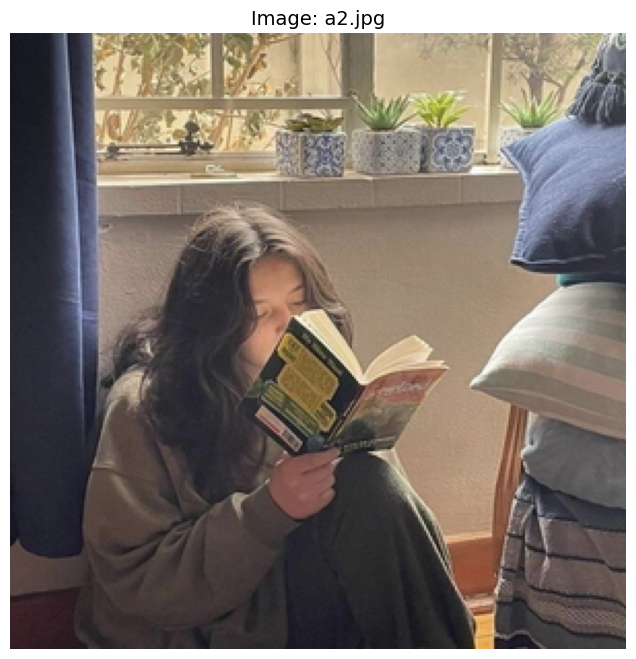


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a small holding a bench .
2. a man standing on a table with a street .
3. a man and a white player is on a field .
4. a man is a white in a field .
5. a man in a baseball with a man in a field .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a tennis on a field .


Image 12/13



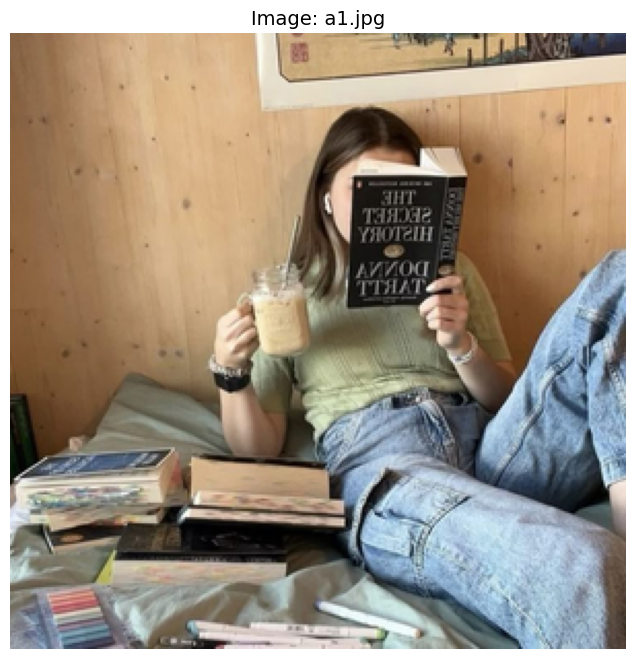


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a woman sitting on a street with a plate .
2. a man in a white and white toilet on a field .
3. a man is a white and a skateboard .
4. a man is a white and white with a toilet .
5. a man is a man in a field of a field .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a white and a white in a field .


Image 13/13



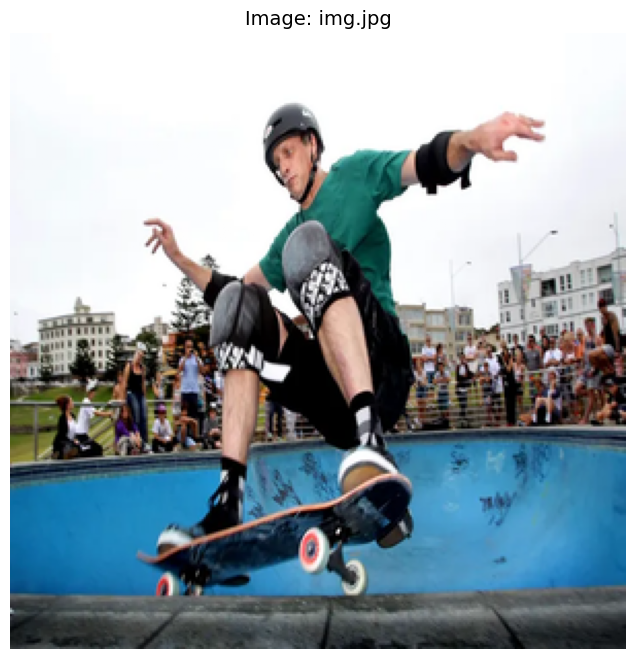


Generated captions (temperature=5.0):
------------------------------------------------------------
1. a man is a white in a field .
2. a man is a tennis in a field .
3. a man is a man in a field .
4. a man is standing in a field .
5. a man is a skateboard in a field .


Most probable caption (greedy):
------------------------------------------------------------
→ a man is a tennis on a field .


                                   STATISTICS                                   
Total images processed: 13
Successful: 13
Failed: 0


In [56]:
network.train(False)
inception.train(False)

# Счетчики для статистики
total_images = len(image_paths)
successful_captions = 0
failed_captions = 0

# Обрабатываем каждое изображение
for idx, image_path in enumerate(image_paths, 1):
    print(f"\n{'='*80}")
    print(f"Image {idx}/{total_images}")
    print(f"{'='*80}\n")

    try:
        # Генерируем подписи с разными настройками
        captions = show_image_with_captions(
            image_path,
            num_captions=5,  # количество вариантов подписей
            temperature=5.0,  # температура для разнообразия
            sample=True       # использовать сэмплирование
        )

        successful_captions += 1

        # Дополнительно: генерируем самую вероятную подпись (детерминированную)
        print("Most probable caption (greedy):")
        print("-" * 60)
        img = load_image(image_path)
        greedy_caption = ' '.join(generate_caption(img, t=1.0, sample=False)[1:-1])
        print(f"→ {greedy_caption}")
        print()

    except Exception as e:
        print(f"✗ Ошибка при обработке {os.path.basename(image_path)}: {e}")
        failed_captions += 1
        continue

# Итоговая статистика
print("\n" + "="*80)
print("STATISTICS".center(80))
print("="*80)
print(f"Total images processed: {total_images}")
print(f"Successful: {successful_captions}")
print(f"Failed: {failed_captions}")
print("="*80)


![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

> Примечание: Это задание адаптировано по материалам курса "Deep Learning" (Skoltech).
